# NLP - Assignment 2

## Imports

In [61]:
import pandas as pd
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from bertopic import BERTopic
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from FuzzyTM import FLSA_W
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import gensim
from gensim import corpora

## Preprocess Data

In [9]:
path = "./us_equities_news_dataset.csv"

# Load the news dataset
news_dataset = pd.read_csv("./us_equities_news_dataset.csv")
news_dataset.head()

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,Why Shares of Chinese Electric Car Maker NIO A...,news,What s happening\nShares of Chinese electric c...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327
1,221516,NIO,NIO only consumer gainer Workhorse Group amon...,news,Gainers NIO NYSE NIO 7 \nLosers MGP Ingr...,2020-01-18,Seeking Alpha,https://invst.ly/pje9c,2062196
2,221517,NIO,NIO leads consumer gainers Beyond Meat and Ma...,news,Gainers NIO NYSE NIO 14 Village Farms In...,2020-01-15,Seeking Alpha,https://invst.ly/pifmv,2060249
3,221518,NIO,NIO NVAX among premarket gainers,news,Cemtrex NASDAQ CETX 85 after FY results \n...,2020-01-15,Seeking Alpha,https://invst.ly/picu8,2060039
4,221519,NIO,PLUG NIO among premarket gainers,news,aTyr Pharma NASDAQ LIFE 63 on Kyorin Pharm...,2020-01-06,Seeking Alpha,https://seekingalpha.com/news/3529772-plug-nio...,2053096


In [10]:
# Filter dataset to only include articles with 'Nvidia' in the content
nvidia_dataset = news_dataset[news_dataset['content'].str.contains('Nvidia', case=False, na=False)]

In [11]:
# Concatenate title and content columns
nvidia_dataset['content'] = nvidia_dataset['title'] + ' ' + nvidia_dataset['content']

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text,
                    remove_punctuation=True,
                    remove_stopwords=True,
                    lemmatize=False,
                    stem=False,
                    remove_short_words=False,
                    remove_rare_words=False,
                    remove_numbers=True,
                    min_word_length=2):
    """
    Advanced preprocessing function that applies different levels of text processing.

    Parameters:
    - text: The text to preprocess.
    - remove_punctuation: Whether to remove punctuation from the text.
    - remove_stopwords: Whether to remove common stopwords.
    - lemmatize: Whether to apply lemmatization to reduce words to their root form.
    - stem: Whether to apply stemming to reduce words to their base form.
    - remove_short_words: Whether to remove short words from the text.
    - remove_rare_words: Whether to remove rare words based on the dataset distribution.
    - remove_numbers: Whether to remove numbers from the text.
    - min_word_length: The minimum length of words to keep in the text.

    Returns:
    - Preprocessed text as tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [token.lower() for token in tokens]

    # Remove numbers if specified
    if remove_numbers:
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

    # Remove non-alphabetic characters (punctuation)
    if remove_punctuation:
        tokens = [re.sub(r'[^a-zA-Z]', '', token) for token in tokens]

    # Remove stopwords
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]

    # Lemmatization
    if lemmatize:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Stemming (alternative to lemmatization)
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]

    # Remove short words
    if remove_short_words:
        tokens = [token for token in tokens if len(token) >= min_word_length]

    return tokens

In [13]:
def apply_preprocessing(nvidia_dataset, version='v1'):
    """
    Apply different levels of preprocessing to the dataset.

    Parameters:
    - nvidia_dataset: The Nvidia articles with a 'content' column.
    - version: The version of preprocessing to apply ('v1', 'v2', 'v3', or 'v4').

    Returns:
    - DataFrame with the original content and the preprocessed content in 'preprocessed_content' column.
    """

    if version == 'v1':
        # Basic tokenization and lowercasing
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=False, remove_stopwords=False,
            lemmatize=False, remove_numbers=False, stem=False,
            remove_short_words=False
        ))

    elif version == 'v2':
        # Remove punctuation, stopwords, and numbers, but no lemmatization/stemming
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True,
            lemmatize=False, remove_numbers=False, stem=False,
            remove_short_words=False
        ))

    elif version == 'v3':
        # Advanced preprocessing with stemming, number removal, short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True,
            lemmatize=False, stem=True, remove_numbers=True,
            remove_short_words=True, min_word_length=2
        ))

    elif version == 'v4':
        # Full preprocessing with lemmatization instead of stemming, number removal, and short words removal
        nvidia_dataset['preprocessed_content'] = nvidia_dataset['content'].apply(lambda x: preprocess_text(
            x, remove_punctuation=True, remove_stopwords=True,
            lemmatize=True, remove_numbers=True, stem=False,
            remove_short_words=True, min_word_length=2
        ))

    else:
        raise ValueError("Invalid preprocessing version. Choose from 'v1', 'v2', 'v3', or 'v4'.")

    # Return the DataFrame with original and preprocessed content
    return nvidia_dataset

In [14]:
train_data_v1 = apply_preprocessing(nvidia_dataset, version='v1')  # Basic preprocessing
train_data_v2 = apply_preprocessing(nvidia_dataset, version='v2')  # Intermediate preprocessing
train_data_v3 = apply_preprocessing(nvidia_dataset, version='v3')  # Full preprocessing with stemming
train_data_v4 = apply_preprocessing(nvidia_dataset, version='v4')  # Full preprocessing with lemmatizer

train_data_v1.head()

,id,ticker,title,category,content,release_date,provider,url,article_id,preprocessed_content
24,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,A Central Bank War Just Started And Its Good F...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687,"[central, bank, war, started, good, stock, ecb..."
32,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch Nivida Could Be Falling 6 S...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931,"[stock, watch, nivida, could, falling, stock, ..."
57,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Stocks Dow Drops Nearly 400 Points as Apple ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042,"[stock, dow, drop, nearly, point, apple, lead,..."
78,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,The Zacks Analyst Blog Highlights Advanced Mi...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277,"[zacks, analyst, blog, highlight, advanced, mi..."
82,221597,UBER,The Best Of CES 2020 Revised,opinion,The Best Of CES 2020 Revised With 4 500 comp...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164,"[best, ce, revised, company, bringing, innovat..."


In [64]:
# Flatten the list of lists to get a single list of words
all_tokens_v3 = [word for sublist in train_data_v3['preprocessed_content'] for word in sublist]

# Get the 50 most common words
common_words_v3 = Counter(all_tokens_v3).most_common(50)

# Print the most common 50 words and their respective frequencies
print('Most common 50 words and respective frequencies:\n')
for i, (word, freq) in enumerate(common_words_v3, 1):
    print(f'{i:<2}- {word:<15} {freq}')

Most common 50 words and respective frequencies:

1 - stock           16293
2 - year            16074
3 - company         15430
4 - nasdaq          14831
5 - zacks           11672
6 - market          10684
7 - earnings        10457
8 - nvidia          9805
9 - quarter         8718
10- share           8282
11- growth          7409
12- revenue         7334
13- billion         6322
14- also            6220
15- nyse            6159
16- technology      5586
17- estimate        5547
18- new             5150
19- investor        5036
20- million         4806
21- rank            4789
22- last            4759
23- week            4594
24- inc             4564
25- expected        4280
26- day             4199
27- report          4161
28- price           4134
29- nvda            4084
30- buy             4067
31- trade           4037
32- investment      3904
33- one             3874
34- time            3862
35- data            3856
36- high            3855
37- strong          3688
38- per           

In [77]:
print(f"Number of unique words: {len(set(all_tokens_v3)):,}")
print(f"Lexical richness: {len(set(all_tokens_v3))/len(all_tokens_v3):.4f}")

Number of unique words: 29,071
Lexical richness: 0.0211


## Helper functions

In [68]:
def remove_top_bottom_words(preprocessed_content, top_percent=10, bottom_percent=10, words_to_exclude=None):
    """
    Remove top-n% and bottom-n% words based on frequency and exclude specified words.

    Parameters:
    - preprocessed_content: list of lists, the preprocessed content
    - top_percent: int, the top n% of words to remove
    - bottom_percent: int, the bottom n% of words to remove
    - words_to_exclude: set, the words to exclude

    Returns:
    - list of lists, the content with specified words removed
    """
    # Flatten the list of lists to get a single list of words
    all_words = [word for sublist in preprocessed_content for word in sublist]
    
    # Get the word frequencies
    word_freq = Counter(all_words)
    
    # Calculate the number of words to remove
    total_words = len(word_freq)
    top_n = int(total_words * top_percent / 100)
    bottom_n = int(total_words * bottom_percent / 100)
    
    # Get the top-n% and bottom-n% words
    top_words = set([word for word, freq in word_freq.most_common(top_n)])
    bottom_words = set([word for word, freq in word_freq.most_common()[:-bottom_n-1:-1]])
    
    # Combine the words to exclude
    words_to_remove = top_words | bottom_words
    if words_to_exclude:
        words_to_remove |= words_to_exclude
    
    # Remove the specified words from the content
    filtered_content = [[word for word in sublist if word not in words_to_remove] for sublist in preprocessed_content]
    
    return filtered_content

### LDA

In [16]:
def compute_coherence_values_lda(train_data_list, dictionary, max_topics=20):
    """
    Compute coherence values for different numbers of topics in LDA model.

    Parameters:
    - train_data_list: List of tokenized documents.
    - dictionary: Gensim dictionary.
    - max_topics: Maximum number of topics to test.

    Returns:
    - coherence_values: List of coherence values for each number of topics.
    - optimal_num_topics: The optimal number of topics based on maximum coherence.
    """

    # Create Document-Term Matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list]

    coherence_values = []

    # Iterate over different numbers of topics
    for num_topics in range(2, max_topics + 1):
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Compute coherence score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=train_data_list, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())

    # Find the optimal number of topics (maximum coherence)
    optimal_num_topics = coherence_values.index(max(coherence_values)) + 2  # +2 because range starts from 2

    return coherence_values, optimal_num_topics

In [17]:
def plot_coherence_scores_lda(coherence_values, max_topics):
    """
    Plot the coherence scores to visualize the elbow method.

    Parameters:
    - coherence_values: List of coherence values.
    - max_topics: Maximum number of topics tested.
    """
    x = range(2, max_topics + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(x, coherence_values, marker='o')
    plt.title('Coherence Scores vs. Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(x)
    plt.grid()
    plt.show()

### FLSA-W

In [18]:
def plot_elbow_curve(topic_nums, coherence_scores):
    """
    Create an elbow plot for the coherence scores vs. number of topics.

    Parameters:
    - topic_nums: list of number of topics tested.
    - coherence_scores: list of coherence scores for each number of topics.
    """
    plt.figure(figsize=(8, 5))
    plt.plot(topic_nums, coherence_scores, marker='o')
    plt.title('FLSA-W Elbow Plot: Number of Topics vs Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

### BERTopic

In [19]:
def print_bertopic_topics(topic_model):
    """
    Print topics generated by BERTopic.

    Parameters:
    - topic_model: the trained BERTopic model
    """
    topics = topic_model.get_topics()
    for topic_num, words in topics.items():
        # Ignore the '-1' topic, which is typically noise in BERTopic
        if topic_num == -1:
            continue
        print(f"Topic {topic_num}: {', '.join([word[0] for word in words])}")

## Train Topic Models

In [43]:
def train_topic_model(train_data, model_type='LDA', max_topics=20): # TODO: set number of words per topic, set number of topics (maybe experiment)
    """
    Train a topic model on the given training data.

    Parameters:
    - train_data: list of str, the text to train the model on
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - max_topics: int, the maximum number of topics to test

    Returns:
    - model: the trained model
    - topics: the topics generated by the model
    """

    train_data_list_string = [' '.join(tokens) for tokens in train_data['preprocessed_content']]
    train_data_list_tokens = train_data['preprocessed_content'].tolist()  # This should already be a list of lists


    if model_type == 'LDA':
        # Create Gensim dictionary
        dictionary = corpora.Dictionary(train_data_list_tokens)

        # Compute coherence values and find optimal number of topics
        coherence_values, optimal_num_topics = compute_coherence_values_lda(train_data_list_tokens, dictionary, max_topics)

        # Plot coherence scores
        plot_coherence_scores_lda(coherence_values, max_topics)

        # Create Document-Term Matrix
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in train_data_list_tokens]

        # Train LDA model with optimal number of topics
        lda_model = gensim.models.LdaModel(
            doc_term_matrix,
            num_topics=optimal_num_topics,
            id2word=dictionary,
            random_state=42,
            passes=10,
            alpha='auto'
        )

        # Get topics (top words in each topic)
        topics = lda_model.print_topics(num_words=10)

        return lda_model, topics

    elif model_type == 'FLSA-W':
        best_flsa_w_coherence = -1
        best_flsa_w_model = None
        best_flsa_w_topics = None
        flsa_w_coherence_scores = []
        flsa_w_topic_nums = []

        for num_topics in range(2, max_topics + 1):
            flsa_w_model = FLSA_W(
                input_file=train_data_list_tokens,
                num_topics=num_topics,
                num_words=10
            )
            pwgt, ptgd = flsa_w_model.get_matrices()  # This trains the model
            coherence_score = flsa_w_model.get_coherence_score()
            flsa_w_coherence_scores.append(coherence_score)
            flsa_w_topic_nums.append(num_topics)

            if coherence_score > best_flsa_w_coherence:
                best_flsa_w_coherence = coherence_score
                best_flsa_w_model = flsa_w_model
                best_flsa_w_topics = flsa_w_model.show_topics(representation='words')

        return best_flsa_w_model, best_flsa_w_topics, (flsa_w_topic_nums, flsa_w_coherence_scores)
    
    elif model_type == 'BERTopic':
        # Train BERTopic model
        topic_model = BERTopic()
        topics, _ = topic_model.fit_transform(train_data_list_string)

        return topic_model, topics

    else:
        raise ValueError("Invalid model_type. Choose from 'LDA', 'FLSA-W', 'BERTopic'.")

In [54]:
def train_on_versions(data_versions, model_type, max_topics=20):
    """
    Train a topic model on different versions of the data.

    Parameters:
    - data_versions: list of DataFrames, each containing a separate version of preprocessed data.
    - model_type: str, the type of model to train ('LDA', 'FLSA-W', 'BERTopic')
    - max_topics: int, the maximum number of topics to generate

    Returns:
    - models: list of trained models
    - topics: list of topics generated by the models
    """

    models = []
    topics = []

    # Train model on different versions
    for i, data_v in enumerate(data_versions):
        print(f"Training model on version {i + 1}")
        model, topic = train_topic_model(data_v, model_type=model_type, max_topics=max_topics)
        print(f"Finished training model on version {i + 1}")
        models.append(model)
        topics.append(topic)

    return models, topics

## Evaluation

### Qualitative

In [22]:
def inspect_model(topic_model):
    """
    Inspect the topics generated by a trained topic model.

    Parameters:
    - topic_model: the trained topic model.
    """
    return topic_model.get_topics(), topic_model.get_info(), topic_model.get_topic_embeddings(), topic_model.get_vocabulary(), topic_model.get_vocabulary_size() # TODO: decide on metrics

### Quantitative

In [23]:
def evaluate_model(topic_model):
    """
    Evaluate the quality of a trained topic model using various metrics.

    Parameters:
    - topic_model: the trained topic model.
    """
    return topic_model.get_coherence_score(), topic_model.get_diversity_score(), topic_model.get_interpretability_score() # TODO: decide which metric (I think we only need coherence)

## Iteration 1

### LDA

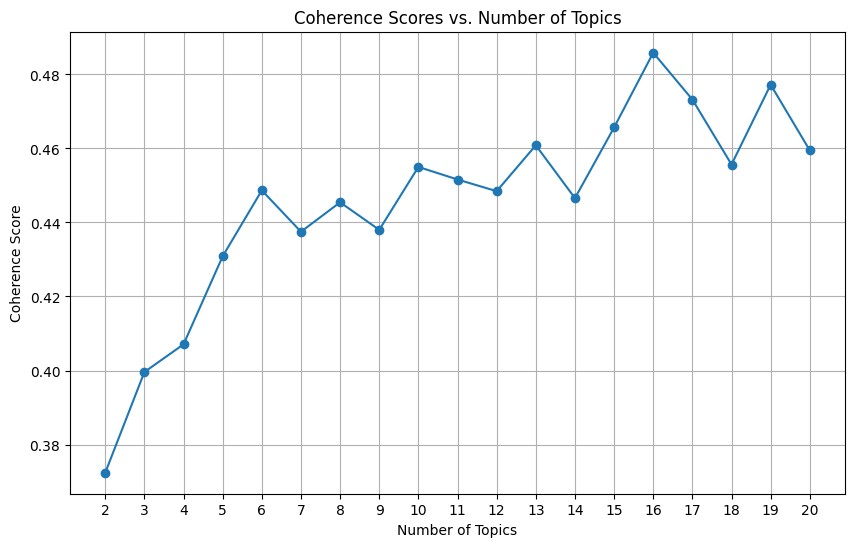

(0, '0.011*"stock" + 0.008*"market" + 0.006*"company" + 0.006*"time" + 0.006*"like" + 0.006*"day" + 0.005*"one" + 0.005*"tech" + 0.005*"nasdaq" + 0.004*"trading"')
(1, '0.013*"market" + 0.011*"week" + 0.009*"year" + 0.007*"could" + 0.007*"last" + 0.006*"rate" + 0.006*"investor" + 0.006*"might" + 0.006*"fed" + 0.005*"month"')
(2, '0.022*"year" + 0.022*"stock" + 0.017*"earnings" + 0.016*"industry" + 0.015*"zacks" + 0.014*"estimate" + 0.013*"nasdaq" + 0.011*"share" + 0.011*"company" + 0.010*"investor"')
(3, '0.035*"nvidia" + 0.016*"amd" + 0.015*"year" + 0.013*"share" + 0.012*"chip" + 0.012*"revenue" + 0.012*"intel" + 0.010*"company" + 0.010*"gaming" + 0.010*"analyst"')
(4, '0.015*"company" + 0.011*"technology" + 0.011*"nasdaq" + 0.009*"intel" + 0.009*"driving" + 0.008*"car" + 0.008*"nvidia" + 0.006*"new" + 0.006*"also" + 0.006*"apple"')
(5, '0.015*"china" + 0.011*"said" + 0.010*"percent" + 0.008*"trade" + 0.007*"market" + 0.007*"company" + 0.007*"billion" + 0.006*"year" + 0.006*"trump" + 

In [24]:
LDA_model, LDA_topics = train_topic_model(train_data_v1, model_type='LDA', max_topics=20)

# Print topics
for topic in LDA_topics:
    print(topic)

### FLSA-W

FLSA-W Topics with Word Probabilities:

(0, '0.0005*"gmt" + 0.0004*"uncover" + 0.0004*"performer" + 0.0004*"ounce" + 0.0004*"esp" + 0.0004*"unchanged" + 0.0004*"traded" + 0.0004*"nasdaq" + 0.0004*"company" + 0.0004*"towards"')
(1, '0.0003*"premarket" + 0.0002*"company" + 0.0002*"nasdaq" + 0.0002*"market" + 0.0002*"stock" + 0.0002*"also" + 0.0002*"troy" + 0.0002*"new" + 0.0002*"share" + 0.0002*"year"')
(2, '0.0013*"nvda" + 0.0013*"nvidia" + 0.0013*"corporation" + 0.0012*"nasdaq" + 0.0012*"inc" + 0.0012*"com" + 0.0012*"investing" + 0.0011*"rank" + 0.0011*"stock" + 0.0011*"broader"')
(3, '0.0101*"book" + 0.0081*"evolution" + 0.0077*"mind" + 0.0074*"richard" + 0.0069*"science" + 0.0064*"certainty" + 0.0062*"modern" + 0.006*"professor" + 0.0058*"knowledge" + 0.0043*"unstoppable"')


FLSA-W Topics:

Topic 1: gmt, uncover, performer, ounce, esp, unchanged, traded, nasdaq, company, towards
Topic 2: premarket, company, nasdaq, market, stock, also, troy, new, share, year
Topic 3: nvda, nvidia, c

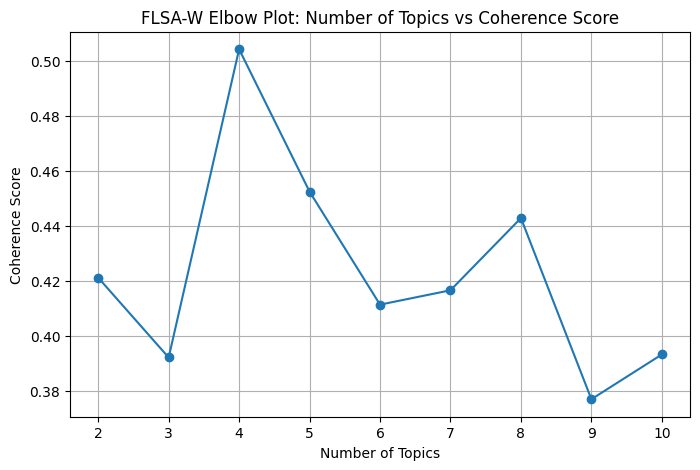

In [58]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, (flsa_w_topic_nums, flsa_w_coherence_scores) = train_topic_model(train_data_v3, model_type='FLSA-W', max_topics=10)

# Show the topics generated
print("FLSA-W Topics with Word Probabilities:\n")
for topic in flsa_w_model.show_topics():
    print(topic)

# Print topics with improved formatting
print("\n\nFLSA-W Topics:\n")
for i, topic in enumerate(flsa_w_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

# Plot the elbow curve
plot_elbow_curve(flsa_w_topic_nums, flsa_w_coherence_scores)

FLSA-W Topics with Word Probabilities:

(0, '0.0003*"premarket" + 0.0002*"company" + 0.0002*"nasdaq" + 0.0002*"market" + 0.0002*"stock" + 0.0002*"also" + 0.0002*"troy" + 0.0002*"new" + 0.0002*"share" + 0.0002*"year"')
(1, '0.0005*"gmt" + 0.0004*"uncover" + 0.0004*"performer" + 0.0004*"ounce" + 0.0004*"esp" + 0.0004*"unchanged" + 0.0004*"traded" + 0.0004*"nasdaq" + 0.0004*"company" + 0.0004*"towards"')
(2, '0.0101*"book" + 0.0081*"evolution" + 0.0077*"mind" + 0.0074*"richard" + 0.0069*"science" + 0.0064*"certainty" + 0.0062*"modern" + 0.006*"professor" + 0.0058*"knowledge" + 0.0043*"unstoppable"')
(3, '0.0013*"nvda" + 0.0013*"nvidia" + 0.0013*"corporation" + 0.0012*"nasdaq" + 0.0012*"inc" + 0.0012*"com" + 0.0012*"investing" + 0.0011*"rank" + 0.0011*"stock" + 0.0011*"broader"')


FLSA-W Topics:

Topic 1: premarket, company, nasdaq, market, stock, also, troy, new, share, year
Topic 2: gmt, uncover, performer, ounce, esp, unchanged, traded, nasdaq, company, towards
Topic 3: book, evolution

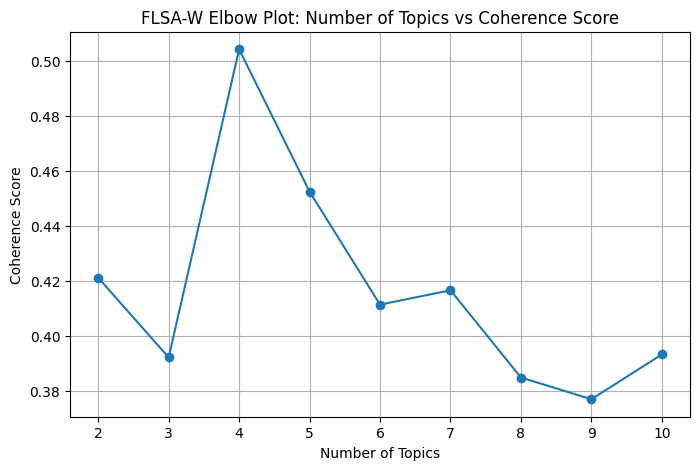

In [59]:
# Train FLSA-W model on the first version of the preprocessed dataset
flsa_w_model, flsa_w_topics, (flsa_w_topic_nums, flsa_w_coherence_scores) = train_topic_model(train_data_v4, model_type='FLSA-W', max_topics=10)

# Show the topics generated
print("FLSA-W Topics with Word Probabilities:\n")
for topic in flsa_w_model.show_topics():
    print(topic)

# Print topics with improved formatting
print("\n\nFLSA-W Topics:\n")
for i, topic in enumerate(flsa_w_topics):
    print(f"Topic {i + 1}: {', '.join(topic)}")

print(f"\nVocabulary size: {flsa_w_model.get_vocabulary_size():,}")

# Plot the elbow curve
plot_elbow_curve(flsa_w_topic_nums, flsa_w_coherence_scores)

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v1, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

## Iteration 2

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v2, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

## Iteration 3

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v3, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

## Iteration 4

### BERTopic

In [ ]:
# Train BERTopic model on the first version of the preprocessed dataset
bertopic_model, bertopic_topics = train_topic_model(train_data_v4, model_type='BERTopic')

# Print the generated BERTopic topics
print("BERTopic Topics:")
print_bertopic_topics(bertopic_model)

Topic Similarity Matrix

In [ ]:
bertopic_model.visualize_heatmap()

## Output of Final Topic Model